In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy import optimize
from scipy import interpolate

In [3]:
def rebound(r, p):
    theta_vec = np.linspace(0, 1, 100)
    phi = p
    rho = r
    Re = list()
    for n in range(len(theta_vec)):
        theta = theta_vec[n]
        b = phi/(1 - np.exp(-100/rho))
        a = 1 - b
        R = a + b*np.exp(-(200*theta-100)/rho)
        Re.append(R)
    return theta_vec, Re

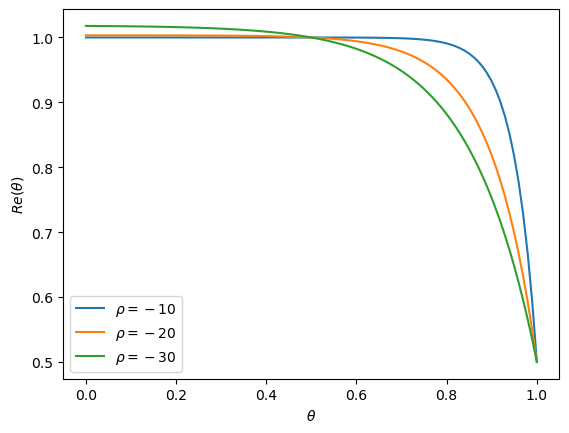

In [5]:
p = 0.5
r1 = -10
r2 = -20
r3 = -30
theta_vec, Re1 = rebound(r1, p)
theta_vec, Re2 = rebound(r2, p)
theta_vec, Re3 = rebound(r3, p)
plt.plot(theta_vec, Re1)
plt.plot(theta_vec, Re2)
plt.plot(theta_vec, Re3)
plt.legend([r'$\rho = -10$',r'$\rho = -20$',r'$\rho = -30$'])
plt.xlabel(r'$\theta$')
plt.ylabel(r'$Re(\theta)$')
plt.show()

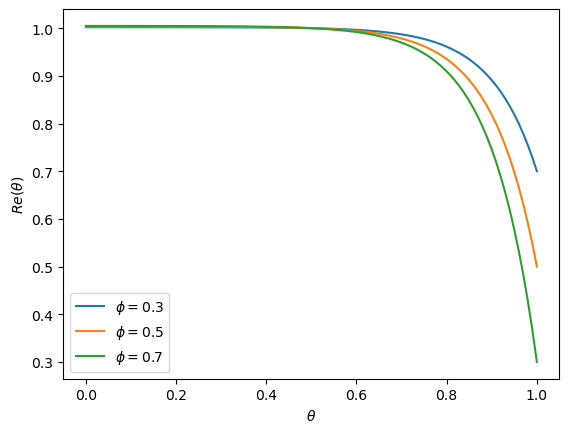

In [7]:
p1 = 0.3
p2 = 0.5
p3 = 0.7
r = -20
theta_vec, Re1 = rebound(r, p1)
theta_vec, Re2 = rebound(r, p2)
theta_vec, Re3 = rebound(r, p3)
plt.plot(theta_vec, Re1)
plt.plot(theta_vec, Re2)
plt.plot(theta_vec, Re3)
plt.legend([r'$\phi = 0.3$',r'$\phi = 0.5$',r'$\phi = 0.7$'])
plt.xlabel(r'$\theta$')
plt.ylabel(r'$Re(\theta)$')
plt.show()

In [9]:
params = {
    'IC': 2850000,
    'G': 431900, 
    'theta': 0.8,
    'n': 15,
    'phi': 0.5,
    'sigma_H': 0.25, 
    'sigma_K': 0.01, 
    'alpha_E': 0.0523,
    'sigma_E': 0.0856,
    'delta': 1.025,
    'H0': 0.0036,
    'K0': 0.43,
    'PE0': 0.24,
    'N': 25,
    'alpha': 0.05,
    'beta': 0.2,
    'r0': 0.031,
    'rR': 0.031,
    'rP': 0.031,
    'rE': 0.06,
    'rho': -20,
    'eps_H': 0.01,
    'eps_P': 0.01,
    'eps_K': 0.01
    }

In [11]:
def f(x):
    IC = params['IC']
    sigma_H = params['sigma_H']
    sigma_K = params['sigma_K']
    alpha_E = params['alpha_E']
    sigma_E = params['sigma_E']
    delta = params['delta']
    H0 = params['H0']
    K0 = params['K0']
    PE0 = params['PE0']
    N = params['N']
    alpha = params['alpha']
    beta = params['beta']
    rE = params['rE']
    rho = params['rho']
    eps_H = params['eps_H']
    eps_P = params['eps_P']
    eps_K = params['eps_K']
    phi = params['phi']
    theta = x
    n = params['n']
    G = params['G']

    t = np.arange(N+1)

    H = IC*H0*np.exp((-np.square(sigma_H)*t/2)+(sigma_H*eps_H*np.sqrt(t)))
    I_OM = (1/delta)*H

    I = np.zeros(N+1)
    I = copy.deepcopy(I_OM)
    I[0] = IC    

    PE = PE0*np.exp((alpha_E-(np.square(sigma_E)/2))*t+sigma_E*eps_P*np.sqrt(t))
    K = IC*K0*np.exp((-np.square(sigma_K)*t/2)+(sigma_K*eps_K*np.sqrt(t)))
    f = np.log(N + 1 - t)/np.log(N)

    b = phi/(1 - np.exp(-100/rho))
    a = 1 - b
    Re = a + b*np.exp(-(200*theta-100)/rho)
    Q = f*Re*K

    R_hat = Q*PE
    R_hat[0] = 0
    R = R_hat

    R_E = np.zeros(N+1)
    for i in np.arange(1, n+1):
        R_E[i] = R[i] - alpha*G - np.max([0, beta*(R[i]-G)]) 

    R_R = np.zeros(N+1)
    for i in np.arange(1, n+1):
        R_R[i] = (1-theta)*(alpha*G + np.max([0, beta*(R[i]-G)]))
    for i in np.arange(n+1, N+1):
        R_R[i] = (1-theta)*R[i]
    
    R_O = np.zeros(N+1)
    for i in np.arange(1, n+1):
        R_O[i] = theta*(alpha*G + np.max([0, beta*(R[i]-G)]))
    R_O[(n+1):(N+1)] = R[(n+1):(N+1)] - R_R[(n+1):(N+1)]  

    NPVE = np.zeros(n+1)
    NPVE[0] = -IC
    for i in np.arange(1, n+1):
        NPVE[i] = (R_E[i] - I_OM[i])/pow((1+rE), i)    
    NPV_E = sum(NPVE)

    y = NPV_E
    return y

In [13]:
def sim(r, p):
    params['rho'] = r
    params['phi'] = p
    x_points = list()
    y_points = list()
    for n in range(14,21):
        params['n'] = n
        x = optimize.brentq(f, 0, 1)
        x_points.append(n)
        y_points.append(x)

    def f_int(x1):
        tck = interpolate.splrep(x_points, y_points)
        return interpolate.splev(x1, tck)

    n_points = 100
    x = np.linspace(10, 20, n_points)
    y = list()
    for n in range(n_points):
        y.append(f_int(x[n]))
    return x, y

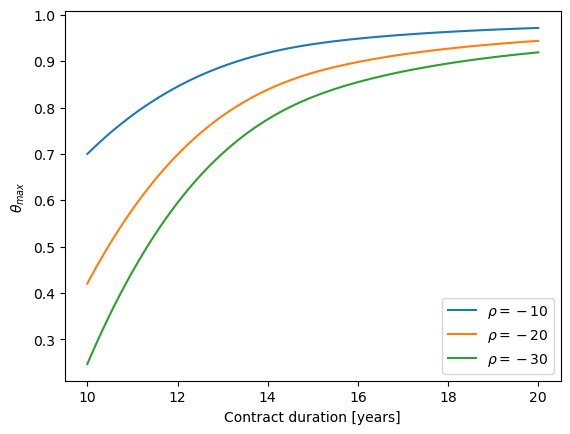

In [15]:
x1, y1 = sim(-10, 0.5)
x2, y2 = sim(-20, 0.5)
x3, y3 = sim(-30, 0.5)

plt.plot(x1,y1)
plt.plot(x2,y2)
plt.plot(x3,y3)
plt.xlabel("Contract duration [years]")
plt.ylabel(r"$\theta_{max}$")
plt.legend([r'$\rho = -10$',r'$\rho = -20$',r'$\rho = -30$'])
plt.show()

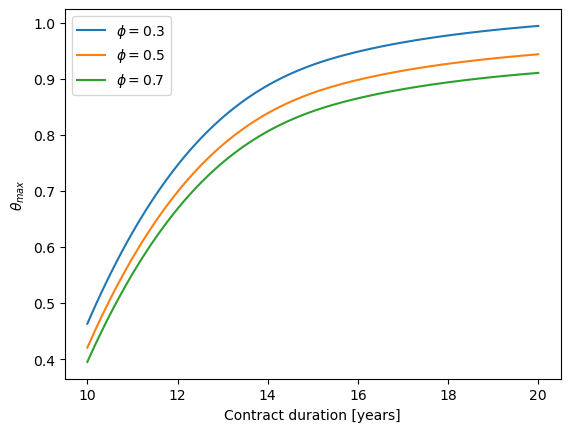

In [17]:
x1, y1 = sim(-20, 0.3)
x2, y2 = sim(-20, 0.5)
x3, y3 = sim(-20, 0.7)
plt.plot(x1,y1)
plt.plot(x2,y2)
plt.plot(x3,y3)
plt.xlabel("Contract duration [years]")
plt.ylabel(r"$\theta_{max}$")
plt.legend([r'$\phi = 0.3$',r'$\phi = 0.5$',r'$\phi = 0.7$'])
plt.show()